## Información integrantes del equipo de trabajo
**Nombre y apellidos (Grupo): Elodie Curcio**

**Nombre y apellidos (Grupo): Guillermo Díaz**

**Nombre y apellidos (Grupo): Miguel Quiroga**

# Dinámica molecular


Para estudiar la dinámica molecular de un fluido o un gas mediante simulaciones podemos resolver las ecuaciones en derivadas totales

$$ m_i\frac{d^2\vec{r}_i(t)}{dt^2} = \vec{F}_i(t)\, ,$$

donde $i$ hace referencia a la partícula $i$-ésima, $\vec{r}_i(t)$ es el vector posición de la partícula en el instante $t$, $m_i$ la mása de la partícula, y $\vec{F}_i(t)$ la fuerza total que siente la partícula a causa de todas las demás en el instante $t$. Definido un potencial de interacción podemos calcular la fuerza. En nuestro caso consideremos el potencial de Lennard-Jones:

$$V(d) = 4\epsilon\left[\left(\frac{\sigma}{d}\right)^{12}-\left(\frac{\sigma}{d}\right)^6\right]\, ,$$

donde $d$ es la distancia entre las partículas,$\epsilon$ la magnitud del mínimo, y $\sigma$ se relaciona con el tamaño efectivo de las partículas. A partir de este potencial, tenemos que

$$\vec{F}_i = -\vec{\nabla}V_i = \sum_{j\neq i} 4\epsilon\left[12\frac{\sigma^{12}}{d_{i,j}^{13}}-6\frac{\sigma^6}{d_{i,j}^7}\right]\hat{r}_{i\rightarrow j}\, ,$$

siendo $\hat{r}_{i\rightarrow j}$ el vector unitario en la dirección $i\rightarrow j$ que conecta las partículas.

## Apartado a:

- Considere una partícula que se mueve dentro de una caja de tamaño L=1 cuadrada en dos dimensiones. Considerar condiciones de contorno fijas (pared rígida). Para ello resolved numéricamente el sistema de ecuaciones diferenciales, por un método numérico. Representad la posición de la partícula a lo largo del tiempo en el plano $XY$. Considerar rebotes elásticos. **EXTRA** Probad a añadir gravedad al problema de una sola partícula.

In [106]:
# Librerías

from numpy import linspace, array, sqrt, sin, zeros, arange
from math import exp, pi
from pylab import plot, show, scatter, xlabel, ylabel, axis, vlines, hlines, xlim, ylim


In [140]:
def f(r, time, gravity):
    xPos = r[0]
    yPos = r[1]
    xVel = r[2]
    yVel = r[3]
    fun = zeros([4], float)
    # fxPos = xVel
    # fyPos = yVel
    # fxVel, fyVel = force(gravity)/mass
    fun[0] = xVel
    fun[1] = yVel
    fun[2:] = force(gravity)
    return fun
    # return array([fxPos, fyPos, fxVel, fyVel], float)

def force(gravity = None):
    finalForce = zeros([2], float)
    if gravity != None:
        finalForce += array([0,-gravity], float)
    return finalForce

def partEvolve(r, timeMax: float, timeStep: float, boxSize, gravity): # aka rungeKutta4
    timeLin = arange(0,timeMax+timeStep, timeStep)
    x = []
    y = []
    for time in timeLin:
        x.append(r[0])
        y.append(r[1])
        print(f'time = {time}/{timeLin[-1]}, pos = {x[-1]}', end='\r')
        
        k1 = timeStep * f(r, time, gravity)
        k2 = timeStep * f(r + k1/2, time + timeStep/2, gravity)
        k3 = timeStep * f(r + k2/2, time + timeStep/2, gravity)
        k4 = timeStep * f(r + k3, time + timeStep, gravity)
        r += (k1 + 2*k2 + 2*k3 + k4) / 6

        # box check
        if abs(r[0]) >= boxSize/2: # x fuera de la caja
            r[2] *= -1
        if abs(r[1]) >= boxSize/2: # y fuera de la caja
            r[3] *= -1
        
    positions = zeros([2,timeLin.size], float)
    positions[0,:] = array(x)
    positions[1,:] = array(y)
    return positions

def plotBox(boxSize):
    vlines(boxSize/2,-boxSize/2,boxSize/2,'k')
    vlines(-boxSize/2,-boxSize/2,boxSize/2,'k')
    hlines(boxSize/2,-boxSize/2,boxSize/2,'k')
    hlines(-boxSize/2,-boxSize/2,boxSize/2,'k')
    xlim([-boxSize/2, boxSize/2])
    ylim([-boxSize/2, boxSize/2])
    axis('equal')


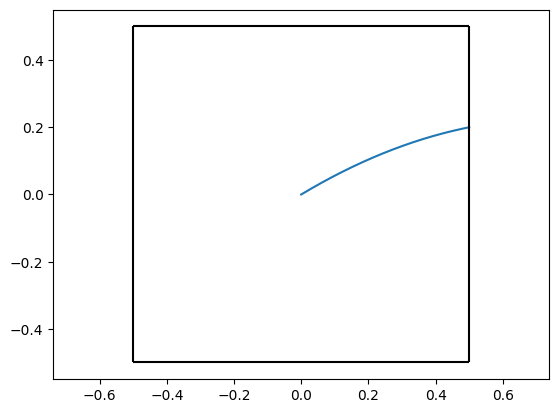

In [141]:
boxSize = 1
sigma = 0.5
epsilon = 0.01
mass = 1
r = array([0,0,0.5,0.3], float)
timeMax = 1
timeStep = 0.001

positions = partEvolve(r, timeMax, timeStep, boxSize, gravity = 0.2)

plot(positions[0,:],positions[1,:])

plotBox(boxSize)
show()

- Incluir una segunda partícula interactuante al problema. Representar la posición de las dos particulas en el plano $XY$, así como la evolución de cada coordenada en el tiempo.  Tomad $\epsilon\sim0.5$ y $\sigma\sim0.01$. **AYUDA** Empezad considerando particulas no interactuantes y luego añadir la interacción. Posicionar las dos partículas y darles velocidades iniciales tales que colisionen para comprobar que la interacción se lleva acabo correctamente.

- Generalizar el programa para considerar $N$ partículas. **CONSEJOS**:
    - Se recomienda tener una matriz que contenga toda la información de las partículas $[(x_i,y_i,v^{(x)}_i,v^{(y)}_i)]$.
    - Empezad considerando pocas particulas e id aumentando el numero de ellas.
    - En el cálculo de la fuerza de interacción, puede darse que dos partículas estén muy juntas, de forma que la aceleración que sienten es muy grande. Se recomienda usar un "cut_off", el cual puede consistir en la transformación $r_{ij}<tol\rightarrow r_{ij}=tol$, donde es recomendable tomar $tol\sim 0.01$ (puede ser necesario ajustar el valor de $tol$ según los valores exactos de $\sigma$ y $\epsilon$ tomados. Para ello se recomienda representar la fuerza en función de la distancia para los valores tomados).
    - Para determinar las posiciones iniciales, es aconsejable crear una cuadrícula centrada en la caja y posicionar las partículas en los nodos de la misma. Para esto pueden ser útiles la función ``mesgrid`` y ``flatten`` de ``numpy``.
    - Para las velocidades, se recomienda generar de forma aleatoria un ángulo que determine la dirección y el módulo del vector velocidad para cada partícula. Este último se recomienda generarlo con una distribución gaussiana, de média 0.5 y desviación 0.1.
    - Cuantas más partículas consideremos, menor debe ser el $\Delta t$ para evitar "perdernos" colisiones. Esto implica que necesitaremos hacer más iteraciones para representar el mismo periodo de tiempo. Se recomienda ir ajustando el numero de partículas, el $\Delta t$ y el número de iteraciones poco a poco, empezando por valores razonables y nunca considerando cantidades demasiado grandes).
    - Posiblemente, la simulación final (con mayor cantidad de partículas, por ejemplo, 100-200, y más larga) tarde un tiempo en ejecutarse. Una vez generados esos datos, se recomienda escribirlos en un fichero para facilitar el resto del trabajo.

## Apartado b:

- Usando las posiciones y velocidades del último 10% de las iteraciones realizadas en la simulación, calculad la energía cinética, potencial y total del sistema a lo largo del tiempo y representarlas en un gráfico.

- Haced un histograma del módulo de las velocidades a lo largo del último 10% de las iteraciones para todas las partículas y superponer la función de distribución teórica:

$$p(v) = \frac{v}{K_BT}e^{-v^2/2K_BT}\, ,$$

donde el valor de $K_BT$ se puede estimar a partir de la energía cinética média por partícula haciendo uso del Teorema de equipartición (recordad que el sistema es de dos dimensiones). **AYUDA** En caso de que los datos no ajusten muy bien a la curva, puede ser por que no se ha hecho una simulación suficientemente larga y por tanto no se a alcanzado el equilibrio térmico.

## Apartado c:

- Repetid la simulación considerando una velocidad media nula y una desviacion de 0.25. Repedid el apartado b para estos nuevos datos. ¿Qué conclusiones podéis sacar?